# NLP exploration with Reddit data
\[_In case you’re unable to see the Atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/other-industries/reddit/main.ipynb)._]

I came across this old article about [Creating a Data Table using Data from Reddit](https://medium.com/swlh/dashboards-in-python-using-dash-creating-a-data-table-using-data-from-reddit-1d6c0cecb4bd) and I enjoyed the idea of [Reddit](https://www.reddit.com/) data exploration. So I thought, why not try it out with Atoti?

That is indeed what I did. It's a pretty short notebook used to explore the data downloaded with [Atoti](https://www.atoti.io/).
Hence I did some additional work:
- [Natural Language Processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing) with [spaCy](https://spacy.io/) to extract [named entities](https://spacy.io/api/annotation#named-entities)
- Real-time dashboarding with Atoti

To achieve real-time, I used threads to trigger the below process flow on regular intervals:

<img src="https://data.atoti.io/notebooks/reddit/thread_task.png" alt="Atoti table" width="800"/>

### Pre-requisite:
You should have the Reddit [API key](https://medium.com/swlh/dashboards-in-python-using-dash-creating-a-data-table-using-data-from-reddit-1d6c0cecb4bd#08db) in order to perform scraping with PRAW.  
Also, uncomment and run the next 2 commands if you haven't install spaCy before.

In [1]:
# if this doesn't work, try running pip install praw in terminal
# !pip install praw spacy watchdog

In [2]:
# This only has to be downloaded once. Uncomment if you haven't
# !python -m spacy download en_core_web_sm

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=reddit" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Atoti table" /></a></div>

In [3]:
import sched
import time
from collections import Counter
from datetime import datetime

import en_core_web_sm
import pandas as pd
import praw
import spacy

import atoti as tt

## NLP with spaCy and Atoti  

I'm going to use spaCy to perform some NLP to extract different named entities from the posting.  
To do so, I have found a nice [reference](https://realpython.com/natural-language-processing-spacy-python/) article. Let's start by loading the [starter model](https://spacy.io/models) from spaCy.

In [4]:
nlp = en_core_web_sm.load()

#### NLP - Extracting named entities with spaCy

Before going into the implementation of the NLP, I'm creating a `entities.csv` to which I will write the entities’ attributes once I extracted them from the post.  
This is in preparation for real-time data loading into Atoti datacube where I could leverage on the `watch` feature of `session.read_csv` to trigger the loading on update of the file.  

In [5]:
entity_file_name = "entities.csv"
entity_file = open(entity_file_name, "w", encoding="utf-8")
entity_file.write("id^category^text^text count\n")
entity_file.flush()

With spaCy, I am going to extract the following [named entities](https://spacy.io/api/annotation#named-entities) from each Reddit posting:  
- Organizations
- Person
- Geographical Locations
- Events
- Product
- NORP (Nationalities/religious/political groups)

In the `get_post_entity` function below, I create a processed [Doc](https://spacy.io/api/doc) object that gives a sequence of [tokens](https://spacy.io/api/token) for each post. Using the tokens, I can identify the entity with its label.  

By using `Counter(list).items()`, I will be able to get a list containing all the terms related to the mentioned entity type and the number of time it appeared. 
Note that you could also get _n_ number of _most common_ items from the list using [Counter](https://docs.python.org/2/library/collections.html). However, I chose to get all items as I could easily use Atoti's filter to achieve the same result. 

The list of entities with its post's id is output to the `entities.csv` created above.  

In [6]:
# convert list of tuples to list of entity with its attributes
def get_entity_list(id, category, item_list):
    # perform data clean up such as trim and removing line break and double-quotes
    return list(
        map(
            lambda a: "^".join(
                str(e)
                if isinstance(e, int)
                else "{}".format(str(e).strip().replace("\n", " "))
                for e in (
                    (
                        id,
                        category,
                    )
                    + a
                )
            ),
            list(item_list),
        )
    )


# for each posting/title, we extract the entities
def get_post_entity(id, text):
    post_entity = []
    org_list = []
    person_list = []
    gpe_list = []
    event_list = []
    product_list = []
    norp_list = []

    nlp_text = nlp(text)
    # ent is a Span object with various attributes
    for ent in nlp_text.ents:
        if ent.label_ == "ORG":
            org_list.append(ent.text)
        elif ent.label_ == "PERSON":
            person_list.append(ent.text)
        elif ent.label_ == "GPE":
            gpe_list.append(ent.text)
        elif ent.label_ == "EVENT":
            event_list.append(ent.text)
        elif ent.label_ == "PRODUCT":
            product_list.append(ent.text)
        elif ent.label_ == "NORP":
            product_list.append(ent.text)

    org = Counter(org_list).items()
    post_entity = get_entity_list(id, "Organization", org)

    person = Counter(person_list).items()
    post_entity = post_entity + get_entity_list(id, "Person", person)

    gpe = Counter(gpe_list).items()
    post_entity = post_entity + get_entity_list(id, "Geographical Location", gpe)

    event = Counter(event_list).items()
    post_entity = post_entity + get_entity_list(id, "Event", event)

    products = Counter(product_list).items()
    post_entity = post_entity + get_entity_list(id, "Product", products)

    norp = Counter(norp_list).items()
    post_entity = post_entity + get_entity_list(id, "NORP", norp)

    if len(post_entity) > 0:
        entity_file.writelines("%s\n" % x for x in post_entity)

    return post_entity

#### NLP - Preprocessing with spaCy

Through preprocessing, I normalized the text:
- lowercase
- remove [stop words](https://en.wikipedia.org/wiki/Stop_words) (words that doesn't add much meaning to the sentence) and punctuation symbols
- [lemmatizes](https://en.wikipedia.org/wiki/Lemmatisation) each token.

This way, the named entities extracted can easily be grouped to compute the number of times it is mentioned.

In [7]:
# https://realpython.com/natural-language-processing-spacy-python/
def is_token_allowed(token):
    if not token or not token.text.strip() or token.is_stop or token.is_punct:
        return False
    return True


def preprocess_token(token):
    # Reduce token to its lowercase lemma form
    return token.lemma_.strip().lower()


def normalize(category, id, post):
    nlp_text = nlp(post)

    complete_filtered_tokens = [
        preprocess_token(token) for token in nlp_text if is_token_allowed(token)
    ]

    lemmatized_sentence = " ".join(complete_filtered_tokens)

    if category == "title":
        get_post_entity(id, lemmatized_sentence)

    return lemmatized_sentence

Normalizing the post invokes `get_post_entity`, triggering the extraction of named entities into csv.

## Using PRAW to connect to Reddit

[PRAW](https://praw.readthedocs.io/en/latest/) is the Python Reddit API Wrapper that we used to download the submissions from the _subreddits_.
I'm not going into the details of the data scraping.  
**You can check out how you can get the API key from my article on [Reddit Scraping](https://medium.com/atoti/reddit-data-analytics-trilogy-1-data-scraping-with-praw-89f3df7dfa90#eb02)**.  

While the below variables are placeholders for the Reddit API keys, it is __NOT recommended__ to add these variables in your source files and commit them. Instead, secure your API keys for example, using environment variable instead. Refer to the article on [securely storing configuration credentials](http://veekaybee.github.io/2020/02/25/secrets/).


In [8]:
reddit_cid = "placeholder - cid"
reddit_csec = "placeholder - csec"
reddit_ua = "placeholder - ua"

In [9]:
# create a reddit connection
reddit = praw.Reddit(
    client_id=reddit_cid, client_secret=reddit_csec, user_agent=reddit_ua
)

In order to do more analysis, I created a function to get the latest postings. This function will allow me to configure the number of postings to download, and from which subreddit to download the postings from.

Unlike the original article, I decided to format `created` into _datetime_ and splitted it into `created_date` and `created_time` as I figured this would allow me to have consolidated view on date level or drill down to the time level.

Referencing the [PRAW documentation](https://praw.readthedocs.io/en/latest/code_overview/models/submission.html#submission) for the submission attributes, I added _id_ and _author_ to the list as well. Important to note is that for real-time, I will be polling the latest 100 postings at a 30 seconds intervals. Potentially there will be duplicated postings across the pollings. Storing the _id_ allows me to **leverage on Atoti's capability to update existing posts instead of inserting duplicated postings**.

In [10]:
def get_latest_posts(subreddit, count):
    # list for df conversion
    _posts = []
    # return 100 new posts from wallstreetbets
    new_bets = reddit.subreddit(subreddit).new(limit=count)
    # return the important attributes
    for post in new_bets:
        # normalize the post and perform NLP named entities extraction
        lemmatized_post = normalize("post", post.id, post.selftext)
        lemmatized_title = normalize("title", post.id, post.title)
        _posts.append(
            [
                post.id,
                post.author,
                post.title,
                post.score,
                post.num_comments,
                post.selftext,
                lemmatized_post,
                lemmatized_title,
                post.created,
                post.pinned,
                post.total_awards_received,
            ]
        )

    # create a dataframe
    _posts = pd.DataFrame(
        _posts,
        columns=[
            "id",
            "author",
            "title",
            "score",
            "comments",
            "post",
            "lemmatized post",
            "lemmatized title",
            "created",
            "pinned",
            "total awards",
        ],
    )

    _posts["created"] = pd.to_datetime(_posts["created"], unit="s")
    _posts["created date"] = pd.to_datetime(_posts["created"], unit="s").dt.date
    _posts["created time"] = pd.to_datetime(_posts["created"], unit="s").dt.time
    _posts["subreddit"] = subreddit

    return _posts

To kickstart, I test downloaded the newest 500 post from the subreddit _wallstreetbets_.  
This data will be loaded into Atoti's **in-memory datacube** later on. This means that the **amount of data that can be loaded is limited only by the hosting machine's capacity**. You could adjust the number of postings you want to look at according to your machine's memory capacity.

In [11]:
posts = get_latest_posts("wallstreetbets", 500)
entity_file.flush()

# check the number of posts retrieved
len(posts)

500

I adapted the below code from the original article and used the Reddit's title instead of post for NLP. Mainly because the Subreddits that I chose has more text in the title than the post.  
The function uses Pandas dataframe to compute some simple statistics about the text in the posts.

In [12]:
def get_nlp_features(_posts):
    # copy the dataframe
    df = _posts.copy()
    # count words in post
    df["words"] = df["title"].apply(lambda x: len(x.split()))
    # count characters in post
    df["chars"] = df["title"].apply(lambda x: len(x.replace(" ", "")))
    # calculate word density
    df["word density"] = (df["words"] / (df["chars"] + 1)).round(3)
    # count unique words
    df["unique words"] = df["title"].apply(lambda x: len(set(w for w in x.split())))
    # percent of unique words
    df["unique density"] = (df["unique words"] / df["words"]).round(3)

    return df

By running the function above on the posts that I have downloaded, we will get a dataset with similar structure to the original article.

In [13]:
df = get_nlp_features(posts)
df.head(3)

,id,author,title,score,comments,post,lemmatized post,lemmatized title,created,pinned,total awards,created date,created time,subreddit,words,chars,word density,unique words,unique density
0,13wm299,Silverpatriot7,Cramer you old dog! I’m sure they are the next...,5,3,,,cramer old dog sure one ☠ ️,2023-05-31 13:17:06,False,0,2023-05-31,13:17:06,wallstreetbets,14,47,0.292,14,1.000
1,13wll77,predictany007,"Fed's Loretta Mester on rate hikes: ""I don't r...",11,8,,,fed loretta mester rate hike compelling reason...,2023-05-31 12:57:43,False,0,2023-05-31,12:57:43,wallstreetbets,15,72,0.205,15,1.000
2,13wleac,CSmith89,As the lobbying powerhouse fights for its surv...,5,1,,,lobby powerhouse fight survival president cbi ...,2023-05-31 12:49:39,False,0,2023-05-31,12:49:39,wallstreetbets,17,85,0.198,15,0.882


In [14]:
df.dtypes

id                          object
author                      object
title                       object
score                        int64
comments                     int64
post                        object
lemmatized post             object
lemmatized title            object
created             datetime64[ns]
pinned                        bool
total awards                 int64
created date                object
created time                object
subreddit                   object
words                        int64
chars                        int64
word density               float64
unique words                 int64
unique density             float64
dtype: object

In [15]:
def cast_df_types(reddit_df):
    reddit_df[
        [
            "id",
            "author",
            "title",
            "post",
            "lemmatized post",
            "lemmatized title",
            "created time",
            "subreddit",
        ]
    ] = reddit_df[
        [
            "id",
            "author",
            "title",
            "post",
            "lemmatized post",
            "lemmatized title",
            "created time",
            "subreddit",
        ]
    ].astype(
        str
    )

    reddit_df["created date"] = pd.to_datetime(df["created date"])

    # waiting for fix for https://github.com/atoti/atoti/issues/324
    reddit_df["post"] = reddit_df["post"].replace({"": "N/A"})
    reddit_df["lemmatized post"] = reddit_df["lemmatized post"].replace({"": "N/A"})
    reddit_df["lemmatized title"] = reddit_df["lemmatized title"].replace({"": "N/A"})

In [16]:
cast_df_types(df)

## Atoti cube creation for NLP analysis

Finally we can get started with Atoti. Let's create a session with the [sampling_mode](https://docs.atoti.io/0.4.2/lib/atoti.html#module-atoti.sampling) to set full, so that I can see all the data once it is loaded.

In [17]:
session = tt.Session(user_content_storage="./content")

#### Atoti datastores

I will create a `Reddit Posts` store for the data as per the original article. 

In [18]:
reddit_table = session.read_pandas(
    df,
    keys=["id"],
    table_name="Reddit_Posts",
)
reddit_table.head(3)

,author,title,score,comments,post,lemmatized post,lemmatized title,created,pinned,total awards,created date,created time,subreddit,words,chars,word density,unique words,unique density
id,,,,,,,,,,,,,,,,,,
13wb300,xaviervel,Is technical analysis real or just a bunch of ...,3,64,Really curious if it's worth spending the time...,curious worth spend time educate market market...,technical analysis real bunch mumbo jumbo nost...,2023-05-31 03:32:14,False,0,2023-05-31,03:32:14,wallstreetbets,16,82,0.193,15,0.938
13w4upj,callmecrude,Three large cap stocks currently in value terr...,41,91,I’ll keep this short and simple. So many of y’...,short simple y’ fall stock market gambit buy o...,large cap stock currently value territory,2023-05-30 22:55:31,False,0,2023-05-30,22:55:31,wallstreetbets,8,44,0.178,8,1.0
13vwshh,FrogMan2468,$BUD PUTs +$35k (+127%) - Pour One Out for the...,1233,376,N/A,N/A,$ bud put + $ 35k +127 pour real men genius,2023-05-30 17:41:48,False,0,2023-05-30,17:41:48,wallstreetbets,14,54,0.255,14,1.0


For my experiment with spaCy, I create a `Entities` store to store the named entities.  

In [19]:
entity_table = session.read_csv(
    entity_file_name,
    keys=["id", "category", "text"],
    table_name="Entities",
    separator="^",
    types={"text count": tt.type.INT},
)

In [20]:
entity_table.head()

,,,text count
id,category,text,
13wll77,Organization,fed,1
13wkcgt,Product,republican,1
13w0314,Organization,cme,1
13vce6k,Organization,a.i. company,1
13v08nu,Organization,microsoft,1


I join the `Entities` store to `Reddit Posts` which I decided to use as the base store.  
Note that Atoti automatically joins columns with the same name across both stores. You could define your own [conditions for the table join](https://docs.atoti.io/0.4.2/lib/atoti.html?highlight=join#atoti.store.Store.join) otherwise.

In [21]:
reddit_table.join(entity_table)

### Watching file modification for real-time dataloading
Below, I set `watch=True` for the entities.csv such that any update to the file will trigger an upload to the datastore.

In [22]:
from watchdog.events import FileCreatedEvent, FileSystemEventHandler
from watchdog.observers.polling import PollingObserver


class AtotiWatcher(FileSystemEventHandler):
    def on_created(self, event: FileCreatedEvent):
        try:
            if event.src_path.endswith(entity_file_name):
                print("New file", event.src_path)
                entity_table.load_csv(event.src_path, separator="^")
        except Exception as error:
            print(error)

    def on_modified(self, event: FileCreatedEvent):
        try:
            if event.src_path.endswith(entity_file_name):
                print("Modified file", event.src_path)
                entity_table.load_csv(event.src_path, separator="^")
        except Exception as error:
            print(error)


observer = PollingObserver()
observer.schedule(AtotiWatcher(), ".")
observer.start()

#### Atoti cube creation - No measures

By default, Atoti will automatically create hierarchies and measures from the datastore based on the data type of the columns.  
In this case, I prefer to manually create my measures, hence I set the [mode](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_cube) of creation to `no_measures`

In [23]:
cube = session.create_cube(reddit_table, "Reddit", mode="no_measures")

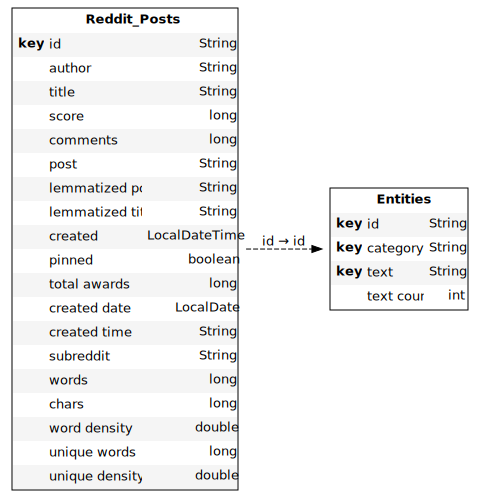

In [24]:
cube.schema

Take a look at the structure of the cube created. Only a `Count` measure is created.

In [25]:
m, l, h = cube.measures, cube.levels, cube.hierarchies
cube

#### Managing hierarchies

Since I am going to create my own measures, I will delete the numeric columns from my hierarchies to avoid confusion with the measures that I will be creating.

In [26]:
h["subreddit"] = [reddit_table["subreddit"]]

#### Measures creation

In default `auto` mode, Atoti will create a `MEAN` and a `SUM` measure.  
However, as I only require `sum` in my simple use case and in order to demonstrate how simple aggregation can be done with Atoti, I created the below measures instead.

In [27]:
m["Text Count"] = tt.agg.sum(entity_table["text count"])
m["Score"] = tt.agg.sum(reddit_table["score"])
m["Comments"] = tt.agg.sum(reddit_table["comments"])
m["Total awards"] = tt.agg.sum(reddit_table["total awards"])
m["Words"] = tt.agg.sum(reddit_table["words"])
m["Chars"] = tt.agg.sum(reddit_table["chars"])
m["Unique words"] = tt.agg.sum(reddit_table["unique words"])
m["Word density"] = tt.agg.sum(reddit_table["word density"])
m["Unique density"] = tt.agg.sum(reddit_table["unique density"])

##### Distinct measure

I use the [`count_distinct`](https://docs.atoti.io/latest/lib/atoti/atoti.agg.count_distinct.html#atoti.agg.count_distinct) function to compute the number of days the data span across.

In [28]:
m["Number days"] = tt.agg.count_distinct(reddit_table["created date"])

##### Cumulative measure

Aggregation with the [`cumulative`](https://docs.atoti.io/latest/lib/atoti/atoti.scope.cumulative_scope.html#atoti.CumulativeScope) scope allows me to see the trend of the posting over the `created` level. By setting the parameter `dense=True`, we can see a continuous plot of the trend even if there are no postings on days in between. 

In [29]:
m["Cumulative Count"] = tt.agg.sum(
    m["contributors.COUNT"], scope=tt.CumulativeScope(level=l["created"], dense=True)
)

In [30]:
session.visualize("Posting Trends")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Atoti Pivot table

Atoti is currently going through UX and performance upgrade. Hang on with us as more features for the Pivot table will come with future release.

## Atoti Pivot table against Dash DataTable

Atoti is currently going through UX and performance upgrade. Hang on with us as more features for the Pivot table will come with future release.  

Let's see how Atoti data table fare compared to the [Dash DataTable](https://medium.com/swlh/dashboards-in-python-using-dash-creating-a-data-table-using-data-from-reddit-1d6c0cecb4bd#be7c) in the original article before the upgrade happened? _Maybe_ Dash Datatable has evolved since the article was last published, let's just enjoy the Atoti table.

In [31]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

I can easily adjust the height of the table or the width of the columns. With the Atoti Editor, I can easily:
- add or remove the levels and measures
- filter the data
- sort the measures
- format the columns

Refer to the GIF below to see how these could be done.

##### Creating table
<img src="https://data.atoti.io/notebooks/reddit/create_pivot_table.gif" alt="Atoti table" width="1080"/>

##### Toggling between different types of table display
<img src="https://data.atoti.io/notebooks/reddit/pivot_table_toggle.gif" alt="Atoti table" width="1080"/>

##### Table adjustment
<img src="https://data.atoti.io/notebooks/reddit/table_adjustments.gif" alt="Atoti table adjustment" width="1080"/>

##### Cell formatting and misc (Only available in atoti v0.4.x and not in the latest version)
<img src="https://data.atoti.io/notebooks/reddit/table_formatting.gif" alt="Atoti cell formatting" width="1080"/>


I can toggle the table from a tabular table to pivot table. Pivot table allows me to drill down on any hierarchies. The measures are computed on the fly as the level changes. 

In [32]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Real-time dashboarding with Atoti

At the moment, I have only loaded data from the subreddit _wallstreetbets_. In the next few cell, I have created functions that allow me to poll the latest 200 postings from some other subreddit groups:
- news
- worldnews
- politics
- technology
- wallstreetbets

Let's switch over to a dashboard that I have prepared in advance by accessing the url from the next cell. After loading the dashboard, trigger the rest of the cells to start the data polling. You can then go back to the dashboard to see it getting refreshed each time new data is downloaded.

In [33]:
session.link(path="/#/dashboard/c7c")

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

I used [`store.load_pandas`](https://docs.atoti.io/latest/lib/atoti/atoti.table.html#atoti.Table.load_pandas) to load the Pandas dataframe incrementally into the `Reddit Posts` store. For the `Entities` store, the csv file is on `watch` mode, hence any update will trigger data to be uploaded into the datastore. Based on the stores' keys, existing data will be updated and new data will be inserted.

In [34]:
def load_new_subreddit(subreddit):
    posts_news = get_latest_posts(subreddit, 200)
    df_news = get_nlp_features(posts_news)
    cast_df_types(df_news)
    reddit_table.load_pandas(df_news)

For demo purpose, I have only set the polling to iterate 10 times with intervals of 30s.

In [35]:
import queue
import threading

should_publish = threading.Event()
update_queue = queue.Queue()


def start_publisher():
    # Do 10 iterations with 30s interval
    starttime = time.time()
    print("Start polling", starttime)
    poll_iteration = 1

    while poll_iteration <= 10:
        print("\rpublishing update ", end="")
        update_queue.put((poll_iteration))
        poll_iteration += 1
        time.sleep(30)
        print("\rawaiting for publishing update", end="")
        should_publish.wait()
        update_queue.join()


def start_update_listener():
    while True:
        poll_iteration = update_queue.get()
        print(poll_iteration, ">>> Start polling from subreddit... ")
        # poll from subreddit
        load_new_subreddit("news")
        print(poll_iteration, "........ Loaded news ")

        load_new_subreddit("worldnews")
        print(poll_iteration, "........ Loaded worldnews ")

        load_new_subreddit("politics")
        print(poll_iteration, "........ Loaded politics ")

        load_new_subreddit("technology")
        print(poll_iteration, "........ Loaded technology ")

        load_new_subreddit("wallstreetbets")
        print(poll_iteration, "........ Loaded wallstreetbets ")
        entity_file.flush()
        print(poll_iteration, ">>> End polling from subreddit... ")
        update_queue.task_done()


listener_thread = threading.Thread(target=start_update_listener, daemon=True)
publisher_thread = threading.Thread(target=start_publisher, daemon=True)

In [36]:
publisher_thread.start()
listener_thread.start()
# start publishing
should_publish.set()

Start polling 1685540413.7264078
publishing update 1 >>> Start polling from subreddit... 


If you would like to stop the data polling before the 10 iterations end, run the below cell.

In [37]:
# pause publishing
should_publish.clear()

#### Dashboard Page - Post Frequency 

This is how the real-time dashboard will look like when the scheduler is running:

<img src="https://data.atoti.io/notebooks/reddit/real-time_dashboarding.gif" alt="Atoti table" width="1080"/>

Using the Subreddit's submission id as a unique key, Atoti is able to update an existing posting and insert new ones.  
You can see the frequency of posting and trend from each Subreddit.  
From the tree map, you can also see which author's posting generates the most comments.

#### Dashboard Page - NLP Stats

Go to second tab of the dashboard to play with the NLP Statistics using quick filters:

<img src="https://data.atoti.io/notebooks/reddit/NLP_Stats.gif" alt="Atoti table" width="1080"/>

__Note that feature values widget has been updated since Atoti v0.5.0 and would look and behave differently.__  
If there are too many values to choose, you can also use the "Label contains..." filter option to do a _partial label_ search. Try selecting Trump and Biden to see the number of postings related to them.

#### Dashboard Page - Author Analysis

Go to third tab of the dashboard for interactive analysis of authors:

<img src="https://data.atoti.io/notebooks/reddit/author_analysis.gif" alt="Atoti table" width="1080"/>

Perform a drillthrough to see the underlying data behind the selected cell.

Have fun exploring the dashboard! Do play around with some of the ootb widgets such as "Quick Page Filter" that allow you to easily filter the page from the dashboard.

<div style="text-align:center"><a href="https://docs.atoti.io/?utm_source=gallery&utm_content=reddit" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti table" /></a></div>